## links 
- https://brian2.readthedocs.io/en/stable/user/input.html#timed-arrays

In [1]:
from brian2 import *
import numpy as np 
import pandas as pd

## Build matrices for protocols 
we can use TimedArrays to simulate protocols of applied voltage. TimedArrays can take one-dimensional input, where each entry corresponds to a constant value of the variable, here voltage, over a specified dt, e.g., dt=100ms. This enables us to efficiently simulate protocols: e.g., 100ms at -80mV followed by 400ms of -30mV would correspond to an array 

`TimedArray(np.array([-80, 30, 30, 30, 30]) * mV, dt=100*ms)`. 

However, it can take two dimensional arrays as well, where the first dimension is time, and the second is neuron idx. Using this feature we can simulate multiple protocols at once, using the same model parameters, but different protocols for every neuron. E.g., simulating two protocols with the same starting voltage, but different activation voltages would correspond to 

`TimedArray(np.array([[-80, -30, -30, -30, -30], [-80, -10, -10, -10, -10]]) * mV, dt=100*ms)`. 


We therefore build matrices for each type of protocol. When the protocols have the same time length, then we can even simulate two types of protocols at once, e.g., for the activation and deactivation protocols, which both last for 800ms. 

## Simulating multiple parameter sets at once 
for simulating multiple parameter sets, each with the same sets of protocols, we just would have to repeat the whole matrix once for every parameter. The parameter themselves would have to be changed somewhere else, though. 


### Activation and deactivation in one matrix 

In [2]:
# activation protocol
duration = 800 
interval_size = 100
n_intervals = int(duration / interval_size)
n_protocols_act = 16
v_baseline = -80

# set baseline 
act_mat = v_baseline * np.ones((n_intervals, n_protocols_act))

# set individual clamps 
act_clamps = np.arange(-80, 80, 10)
for iprot in range(n_protocols_act): 
    act_mat[1:-1, iprot] = act_clamps[iprot]

In [3]:
# deactivation protocol
duration = 800 
interval_size = 100
n_intervals = int(duration / interval_size)
n_protocols_deact = 15
v_baseline = -80

# set baseline 
deact_mat = v_baseline * np.ones((n_intervals, n_protocols_deact))

# set deact phase
deact_mat[1:-3, :] = 70 

# set individual clamps 
deact_clamps = np.arange(-100, 50, 10)
for iprot in range(n_protocols_deact): 
    deact_mat[-3:-1, iprot] = deact_clamps[iprot]

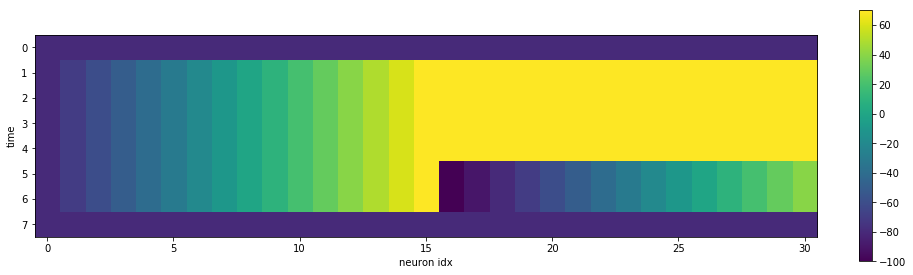

In [4]:
# put together
act_deact_prot_matrix = np.hstack((act_mat, deact_mat))

plt.figure(figsize=(15, 10))
plt.imshow(act_deact_prot_matrix)
plt.colorbar(fraction=.015)
plt.ylabel('time')
plt.xlabel('neuron idx');

## Inactivation has own matrix, as it takes longer

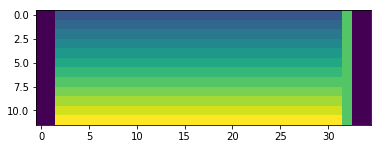

In [5]:
duration = 1750
interval_size = 50
n_intervals = int(duration / interval_size)
n_protocols_inact = 12
v_baseline = -80

# set baseline 
inact_mat = v_baseline * np.ones((n_intervals, n_protocols_inact))
# set deact phase
inact_mat[-3:-2, :] = 30 
# set individual clamps 
inact_clamps = np.arange(-40, 80, 10)
for iprot in range(n_protocols_inact): 
    inact_mat[2:-3, iprot] = inact_clamps[iprot]
    
plt.imshow(inact_mat.T);

## Read in dynamic protocols "v_ap" and "v_ramp"

In [6]:
prot = ['v_ap','v_ramp']
p = 0
protocols = \
pd.read_csv('/home/janfb/qode/lfi-models/lfimodels/channelomics/protocols/k_channels/'+prot[p]+'.dat',sep='\t')

protocols = protocols.drop(protocols.columns[-1],axis=1)

In [7]:
Vs = {}
ts = {}

for iprot, p in enumerate(prot): 
    protocols = pd.read_csv('/home/janfb/qode/lfi-models/lfimodels/channelomics/protocols/k_channels/'+prot[iprot]+'.dat',sep='\t')
    protocols = protocols.drop(protocols.columns[-1],axis=1)

    # extract voltages and time
    protocols1 = protocols.values

    Vs[p] = protocols1[:,1:].T
    ts[p] = protocols1[:,0]   # attention: time step varies, but we will assume that it is constant
    

## Set params

In [8]:
gt_params = [-63, -0.032, 0.5, 15., 15., 5., 40., 4]

area = 20000*umetre**2
gbar_kd = 5e-3*siemens*cm**-2 * area
ek = -90*mV

n_params = 1

noise_std = 0.
sigma_n = noise_std / second
sigma_v = noise_std * mV 

## Define simulation methods 

I define two simulation methods, one for the static protocols for which we can use TimedArrays, and one for dynamic protocols that we need two change the voltage protocol dynamically during the simulation. 

In [9]:
def simulate_protocol_static(params_list, protocol_matrix, dt_prot): 
    
    # the voltage comes from a TimedArray called v_prot, defined below using the protocol matrix
    eqs = Equations('''
                dn/dt = alphav * (1 - n) - betav * n + sigma_n*xi*second**.5 : 1
                alphav = ralpha * (mV**-1) * (v_prot(t, i) - vt - thalpha) / (exp(-(v_prot(t, i) - vt - thalpha) / qalpha) - 1)/ms : Hz
                betav = rbeta * exp(-(v_prot(t, i) - vt - thbeta) / qbeta)/ms : Hz
                I = gbar_kd * n**M * (v_prot(t, i) - ek) : ampere
                vt : volt
                ralpha : 1
                rbeta: 1 
                thalpha: volt
                thbeta: volt 
                qalpha: volt 
                qbeta: volt 
                M : 1                 
                ''')
    
    # we assume one type of param: vt
    n_params = len(params_list)
    dim_param = len(params_list[0])
    n_protocols = protocol_matrix.shape[1]
    
    # repeat protocol matrix for every param
    protocol_matrix = np.tile(protocol_matrix, reps=n_params)
    
    v_prot = TimedArray(protocol_matrix * mV, dt=dt_prot*ms)    

    # define a group with n_protocols * n_params neurons 
    group = NeuronGroup(protocol_matrix.shape[1], eqs,
                        method='milstein')
    
    # set same params for every neuron batch of protocols 
    for param_idx, param_vec in enumerate(params_list):
        
        batch_start_idx = param_idx * n_protocols
        batch_end_idx = (param_idx + 1) * n_protocols
        
        group.vt[batch_start_idx:batch_end_idx] = param_vec[0] * mV 
        group.ralpha[batch_start_idx:batch_end_idx] = param_vec[1] 
        group.rbeta[batch_start_idx:batch_end_idx] = param_vec[2] 
        group.thalpha[batch_start_idx:batch_end_idx] = param_vec[3] * mV
        group.thbeta[batch_start_idx:batch_end_idx] = param_vec[4] * mV
        group.qalpha[batch_start_idx:batch_end_idx] = param_vec[5] * mV
        group.qbeta[batch_start_idx:batch_end_idx] = param_vec[6] * mV
        group.M[batch_start_idx:batch_end_idx] = param_vec[7] 
        
    # record only the results current traces 
    trace = StateMonitor(group, ['I'], record=True)
        
    # duration is given by the protocol
    duration = v_prot.dt * protocol_matrix.shape[0] * second
    
    net = Network([group, trace])
    
    net.run(duration)
    
    # return only current traces
    return net.objects[1]

In [10]:
def simulate_protocol_dynamic(params_list, t_array, v_array, dt_prot=0.1): 
    
    n_params = len(params_list)
    dim_param = len(params_list[0])
    
    # here, voltage is defined as group variable, changed dynamically during the simulation 
    eqs = Equations('''
                dn/dt = alphav * (1 - n) - betav * n + sigma_n*xi*second**.5 : 1
                alphav = ralpha * (mV**-1) * (v - vt - thalpha) / (exp(-(v - vt - thalpha) / (qalpha)) - 1)/ms : Hz
                betav = rbeta * exp(-(v - vt - thbeta) / (qbeta))/ms : Hz
                I = gbar_kd * n**M * (v - ek) : ampere
                v: volt
                vt : volt
                ralpha : 1
                rbeta: 1 
                thalpha: volt
                thbeta: volt 
                qalpha: volt 
                qbeta: volt 
                M : 1                 
                ''')
        
    # as many neurons as param vectors to simulate
    group = NeuronGroup(n_params, eqs, method='milstein')
    
    # set params for every neuron differently
    for param_idx, param_vec in enumerate(params_list):
        
        group.vt[param_idx] = param_vec[0] * mV 
        group.ralpha[param_idx] = param_vec[1] 
        group.rbeta[param_idx] = param_vec[2] 
        group.thalpha[param_idx] = param_vec[3] * mV
        group.thbeta[param_idx] = param_vec[4] * mV
        group.qalpha[param_idx] = param_vec[5] * mV
        group.qbeta[param_idx] = param_vec[6] * mV
        group.M[param_idx] = param_vec[7]
    
    group.v = -80*mV
        
    current_trace = StateMonitor(group, ['I', 'v', 'n'], record=True)
        
    # define network operation to change voltage, executed every dt_prot ms
    @network_operation(dt=dt_prot*ms)
    def update_voltage(t):
        # get idx in time array for time t 
        t_idx = np.where(t_array > t/ms)[0][0]    
        # get corresponding voltage from protocol 
        v_value = v_array[0, t_idx]
        # set voltage for all neurons 
        group.v = v_value * mV + sigma_v * randn()
    
    net = Network([group, update_voltage, current_trace])
    
    net.run(t_array[-1] * ms)
    
    # return current traces 
    return current_trace

In [12]:
n_params = 1
trace_ap = simulate_protocol_dynamic([gt_params] * n_params, ts['v_ap'], Vs['v_ap'], .3)
trace_ramp = simulate_protocol_dynamic([gt_params] * n_params, ts['v_ramp'], Vs['v_ramp'], 1.)
trace_act_deact = simulate_protocol_static([gt_params] * n_params, act_deact_prot_matrix, dt_prot=100)
trace_inact = simulate_protocol_static([gt_params] * n_params, inact_mat, dt_prot=50)

## Plot current traces for each protocol

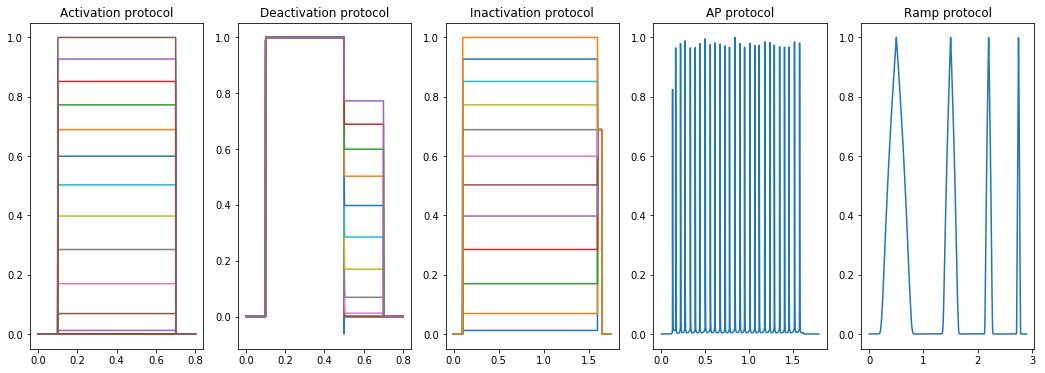

In [17]:
fig, ax = plt.subplots(1, 5, figsize=(18, 6))

plt.sca(ax[0])
plt.plot(trace_act_deact.t, trace_act_deact.I[:16, :].T / np.max(trace_act_deact.I[:16, :].T))
plt.title('Activation protocol');

plt.sca(ax[1])
plt.plot(trace_act_deact.t, trace_act_deact.I[16:31, :].T / np.max(trace_act_deact.I[16:31, :].T))
plt.title('Deactivation protocol');

plt.sca(ax[2])
plt.plot(trace_inact.t, trace_inact.I.T / np.max(trace_inact.I.T))
plt.title('Inactivation protocol');

plt.sca(ax[3])
plt.plot(trace_ap.t, trace_ap.I.T / np.max(trace_ap.I.T))
plt.title('AP protocol');

plt.sca(ax[4])
plt.plot(trace_ramp.t, trace_ramp.I.T / np.max(trace_ramp.I.T ))
plt.title('Ramp protocol');